# Review of Pathfinding Algorithms in the Minihack Environment
### DaisyHack Team for the Artificial Intelligence Fundamental Course, 2023/2024
Cosimo Botticelli, Maria Colella, Michele Mattiello, Nazifa Mosharrat, Roberto Della Rocca

---

### Setting up the environment
Assuming we are in a proper virtual environment, we can setup the environment and import the adequate packages using the following block of code.

In [94]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

from collections import deque
from queue import PriorityQueue
from utilsMinihackSearch import *
from typing import Tuple, List

---

## Hill Climbing Search

For our first search algorithm, we expect a simple and greedy behaviour that can quickly cover large distances but gets stuck at the fist local minimum.

In [95]:
# Function to perform hill climbing algorithm to find a path from start to target
def hill_climb(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    # Initialize the current state with the start position
    current = {'state': start}
    # Initialize the parent dictionary to track paths
    parent = {start: None}  
    
    # Continue the loop until a solution is found or an appropriate condition is met
    while True:
        # Find the highest valued successor based on the heuristic
        neighbor = highest_valued_successors(current, game_map, target, h)
        
        # Check if the heuristic value of the neighbor is less than or equal to the current state
        if h(neighbor['state'], target) <= h(current['state'], target):
            # If true, construct and return the path
            path = build_path_HillClimb(parent, start, target)
            return path
        
        # Update the parent dictionary with the current and neighbor states
        parent[neighbor['state']] = current['state']
        # Move to the neighbor state for the next iteration
        current = neighbor
        
        # Debugging statements
        print("Parent dictionary:", parent)  
        print("Target:", target)
        print("Current state:", current['state'])

# Function to build the path from the parent dictionary
def build_path_HillClimb(parent: dict, start: Tuple[int, int], target: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    current = target
    
    # Continue until reaching the start or a dead end
    while current is not None and current != start:
        # Append the current state to the path
        path.append(current)
        # Check if the current state is not in the parent dictionary
        if current not in parent:
            print(f"Target {target} not reachable from start {start}.")
            return None
        # Move to the parent state for backtracking
        current = parent[current]
    
    # Add the starting point to the path and reverse the order
    path.append(start)
    path.reverse()
    
    return path

# Function to find the highest valued successor based on the heuristic
def highest_valued_successors(node, game_map, target, h):
    # Get valid moves (successors) from the current state
    successors = get_valid_moves(game_map, node['state'])
    # Sort successors based on the heuristic value in descending order
    successors.sort(key=lambda x: h(x, target), reverse=True)
    # Return the highest valued successor
    return {'state': successors[0]}

env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/empty.des",
)
state = env.reset()

#### Empty map
A first simple map is useful to show how the algorithm behaves in a very smooth solution space, with no local minima.

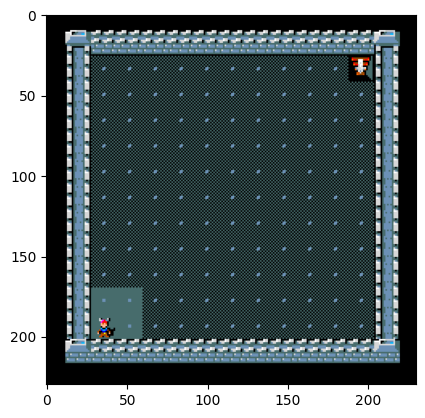

In [96]:
plt.imshow(state['pixel'][70:300, 500:730])

In [97]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

Agent position: (16, 33)
Target position: (6, 43)


The path to the exit is computed and stored, if it does exist.

In [98]:
path = hill_climb(game_map, start, target, manhattan_distance)
path

Target (6, 43) not reachable from start (16, 33).


*here should go the other examples but the algorithm has to be fixed first*

---

## Hill Climbing Search with Backtracking

A variation of our first algorithm goes to show how a little addition can go a long way.

We add backtracking in order to get out of local minima.

In [128]:
def build_path_HillClimb(parent: dict, start: Tuple[int, int], target: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    current = target

    while current is not None and current != start:
        path.append(current)
        current = parent[current]

    path.append(start)  # Add the starting point to the path
    path.reverse()

    return path

def hill_climb(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    # initialize open and close list
    open_list = [start]
    close_list = []
    parent = {start: None}

    while open_list:
        # getting the current node
        current = open_list.pop()
        # adding the node to the close list
        close_list.append(current)

        if current == target:
            path = build_path_HillClimb(parent, start,target)
            return path

        for neighbor in get_valid_moves(game_map, current):
            # check if neighbor in close list, if so continue
            if neighbor in close_list:
                continue

            # compute neighbor h value
            neighbor_h = h(neighbor, target)
            parent[neighbor] = current
            # if neighbor not in open list, adding it
            if neighbor not in open_list:
                open_list.append(neighbor)

    return None

####  Map with a single local minimum
This map has a single local minimum; with a little backtracking we can handle this easily and in fact the character goes around the critical area and gets to the goal.

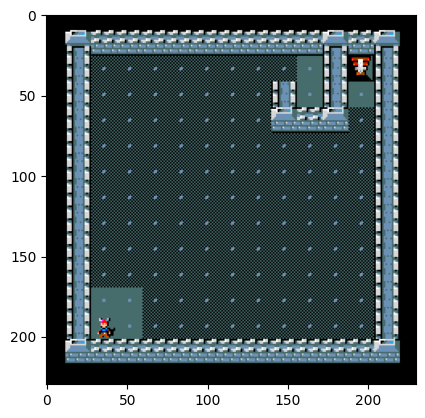

In [129]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/one_local_minimum.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [130]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]

start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

Agent position: (16, 33)
Target position: (6, 43)


In [133]:
founded = 0
finalPath = None
for i in range(30):
    path = hill_climb(game_map, start, target, manhattan_distance)
    if path is not None:
        founded += 1
        finalPath = path

print(f"{founded}/30 correct paths.")

30/30 correct paths.


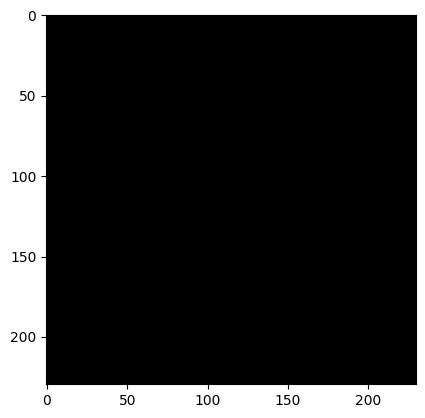

In [103]:
actions = actions_from_path(start, path[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

####  A map with multiple local minima

This map with several local minima tests the limit of this algorithm.

---

## Local Beam Search

With this algorithm we trade off some memory for better exploration capabilities.

The *k* best states are kept in memory and exploder when the current path being explored fails to reach the goal.

This algorithm could be complete for maps of any size with the allocation of infinite memory, in theory.

In practice, it's up to us to choose the best amount of memory to allocate.

In [230]:
import random
import time


def initialize_states(game_map: np.ndarray, start: Tuple[int, int], k: int):

    init_states = [list(random.choice(get_valid_moves(game_map, start))) for _ in range(k)]
    
    current_states = []
    for state in init_states:
        current_states.append({
            'current': tuple(state),
            'explored_nodes': [tuple(state)],
            'path': [tuple(state)]
        })

    return current_states

def get_successors_from_states(game_map: np.ndarray, states: list):

    state_neighbors = []

    for state in states:
        neighbors = get_valid_moves(game_map, state['current'])
        state_neighbors.append({
            'path': state['path'],
            'explored_nodes': state['explored_nodes'],
            'possible_moves': neighbors
        })
        

    return state_neighbors

def get_heuristic_scores(heuristic: callable, neighbors: list):

    scored_moves = []

    for state in neighbors:
        for move in state['possible_moves']:
            score_target = heuristic(move, target)
            score_start = heuristic(start, move)
            scored_moves.append({
                'path': state['path'],
                'explored_nodes': state['explored_nodes'],
                'current': move,
                'distance_from_target': score_target,
                'distance_from_start': score_start
            })
    
    return scored_moves

def assign_probabilities(sorted_array):
    n = len(sorted_array)
    probabilities = [1 / (i + 1) for i in range(n)]
    
    # give the same probability if two elements has the same distance
    for i in range(1, n):
        if sorted_array[i] == sorted_array[i - 1]:
            probabilities[i] = probabilities[i - 1]
    
    return probabilities

def get_next_states(scored_successors: list, k: int, stocastic: bool):

    scored_successors_from_target = sorted(scored_successors, key = lambda x: x['distance_from_target'])
    scored_successors_from_start = sorted(scored_successors, key = lambda x: x['distance_from_start'], reverse=True)
    scored_successors = None

    if scored_successors_from_start[0]['distance_from_start'] - 15 < scored_successors_from_target[0]['distance_from_target'] :
        scored_successors = scored_successors_from_start
    else:
        scored_successors = scored_successors_from_target

    # scored_successors = scored_successors_from_start

    top = []

    if stocastic:
        cont = 0
        while cont < k:
            # top.append(scored_successors[random.randrange(0, len(scored_successors))])
            probability_array = assign_probabilities(scored_successors)
            choice = random.choices(scored_successors, probability_array)[0]
            if choice not in top:
                top.append(choice)
                cont += 1
    else:
        cont = 0
        for succ in scored_successors:
            if cont < k:
                if succ['current'] not in succ['explored_nodes']:
                    succ['explored_nodes'] = succ['explored_nodes'] + [succ['current']]
                    top.append(succ)
                    cont += 1

                
    
    next_states = list()
    
    for s in top:
        next_states.append({
            'current': s['current'],
            'explored_nodes': s['explored_nodes'],
            'path': s['path'] + [s['current']]
        })
    
    return next_states


def local_beam_search(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], heuristic: callable, k: int = 3, max_iter: int = 100, stocastic: bool = False):

    current_states = initialize_states(game_map, start, k)

    for i in range(max_iter):

        state_neighbors = get_successors_from_states(game_map, current_states)

        if len(current_states) == 0 or i == max_iter - 1:
            path = [start] + backup_states[0]['path'] + [move]
            return path
        
        # check if a possible move is the target
        for state in state_neighbors:
            for move in state['possible_moves']:
                if move == target:
                   path = [start] + state['path'] + [move]
                   return path

        scored_successors = get_heuristic_scores(heuristic, state_neighbors)
        backup_states = current_states
        current_states = get_next_states(scored_successors, k, stocastic)

#### Map with two local minima
A map with two local minima, easy to manage for a beam search algorithm.

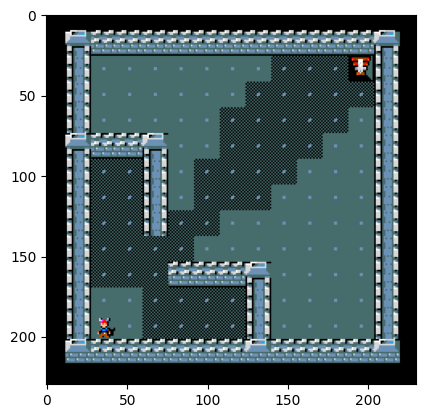

In [231]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/two_local_minima.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [232]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

Agent position: (16, 33)
Target position: (6, 43)


In [233]:
founded = 0
finalPath = None
for i in range(100):
    path = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if path:
        founded += 1
        finalPath = path

print(f"{founded}/100 correct paths.")

100/100 correct paths.


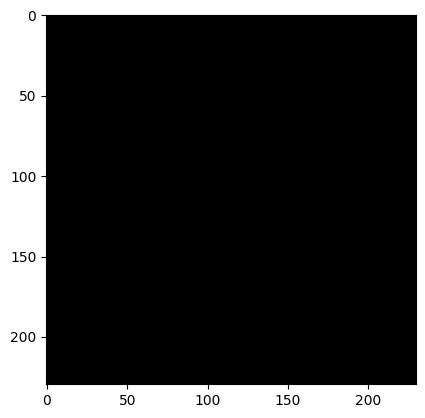

In [234]:
actions = actions_from_path(start, path[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

#### Medium difficulty maze
A maze with multiple local minima, but still manageable for the Local Beam Search.

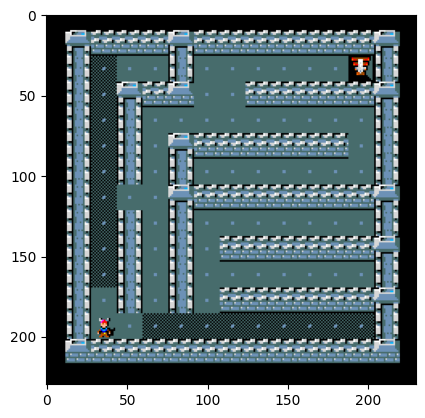

In [197]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/low_diff_maze.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [198]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

Agent position: (16, 33)
Target position: (6, 43)


In [207]:
founded = 0
finalPath = None
for i in range(100):
    path, found = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if found is True:
        founded += 1
        finalPath = path

print(f"{founded}/100 correct paths.")

43/100 correct paths.


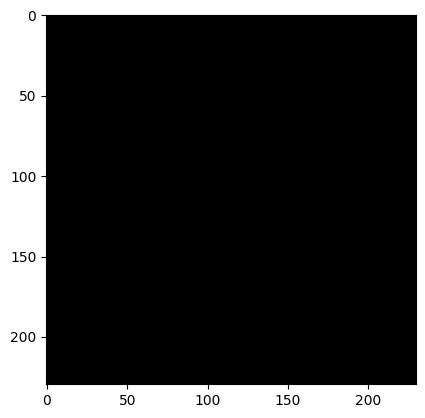

In [208]:
actions = actions_from_path(start, path[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

#### Failure state map
This is an example of a maze that can't be solved by the algorithm.

We can see the player trying to get far away from the starting point and then getting stuck irreversably in a local minima.

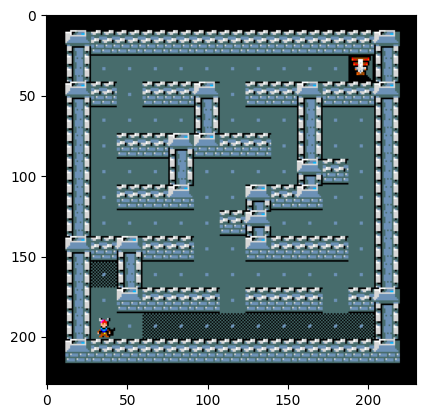

In [209]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/medium_diff_maze.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [210]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

Agent position: (16, 33)
Target position: (6, 43)


In [213]:
founded = 0
finalPath = None
for i in range(100):
    path, found = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if found is True:
        founded += 1
        finalPath = path

print(f"{founded}/100 correct paths.")

0/100 correct paths.


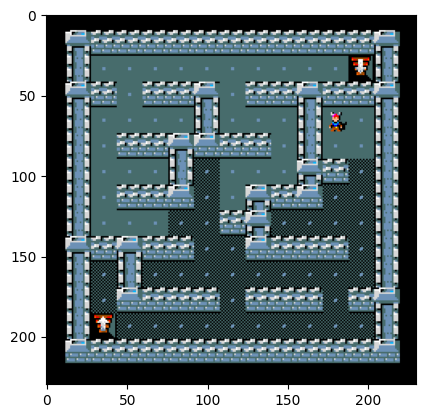

In [214]:
actions = actions_from_path(start, path[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

---

## Genetic Algorithm

A custom genetic algorithm that can build path through evolutive concepts such as selection of best specimens in order to get better and better solutions, and mutation in order to explore good but unpromising paths.